In [ ]:
# Robert Minneker
# CSE 599 G1
# This notebook serves as the main runner for networks and experiments

In [12]:
# imports and constants
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import matplotlib.style as style
import os
import time
import copy
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
model_dir = '/content/drive/MyDrive/Deep Learning Final Project/saved_models/'
data_dir = '/content/drive/MyDrive/Deep Learning Final Project/data'
style.use('seaborn-poster')
style.use('seaborn-talk')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
# First we load the training and testing data using data loader
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/Deep Learning Final Project/data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

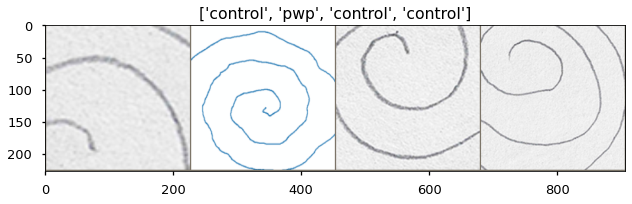

In [29]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [38]:
def plot_acc_and_loss(epochs, train_loss, train_acc, val_loss, val_acc, name):
    style.use('seaborn-poster')
    style.use('seaborn-talk')
    plt.figure()
    plt.plot(epochs, train_loss, label='train')
    plt.plot(epochs, val_loss, label='val')
    plt.title('Training and validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.savefig('/content/drive/MyDrive/Deep Learning Final Project/plots/' 
                + name 
                + '_loss')

    plt.figure()
    plt.plot(epochs, train_acc, label='train')
    plt.plot(epochs, val_acc, label='val')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.savefig('/content/drive/MyDrive/Deep Learning Final Project/plots/' 
                + name 
                + '_acc')

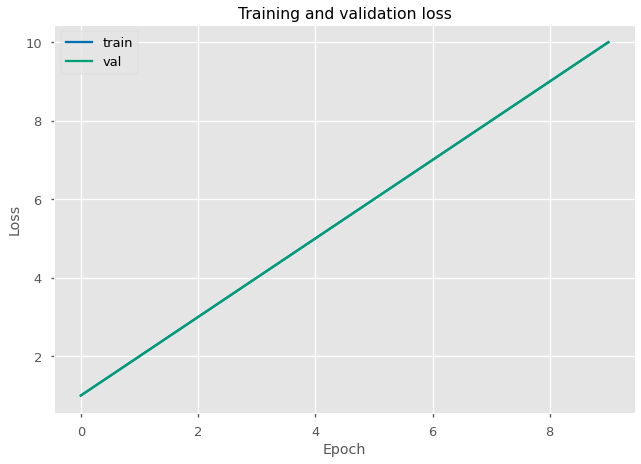

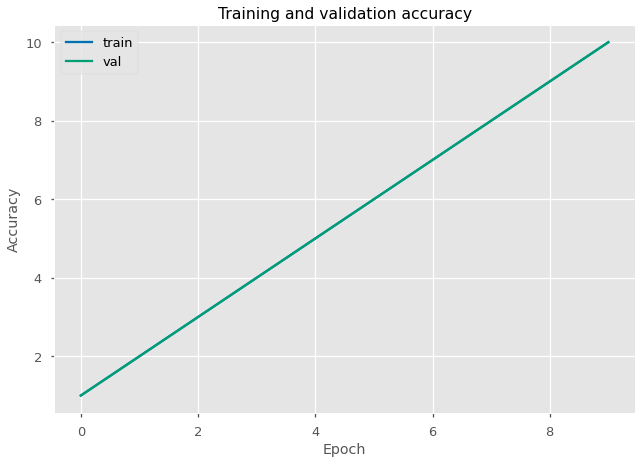

In [41]:
style.use('seaborn-colorblind')
plot_acc_and_loss([x for x in range(10)], 
                  np.linspace(1, 10, 10), 
                  np.linspace(1, 10, 10), 
                  np.linspace(1, 10, 10), 
                  np.linspace(1, 10, 10), 
                  'test2')

In [26]:
style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [9]:
def train_model(model, criterion, optimizer, scheduler, name, num_epochs=25):
    since = time.time()

    model_epochs = []
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # log epochs for plotting
        model_epochs.append(epoch)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            # store values for plot
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    # plot the training and validation loss
    plot_acc_and_loss(model_epochs, train_loss, train_acc, val_loss, val_acc, name)

    return model

In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [89]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/24
----------
train Loss: 0.8743 Acc: 0.5294
val Loss: 0.8175 Acc: 0.5500

Epoch 1/24
----------
train Loss: 0.8910 Acc: 0.5196
val Loss: 0.5269 Acc: 0.7000

Epoch 2/24
----------
train Loss: 0.6283 Acc: 0.7745
val Loss: 0.5850 Acc: 0.7500

Epoch 3/24
----------
train Loss: 0.7080 Acc: 0.6569
val Loss: 0.8130 Acc: 0.6000

Epoch 4/24
----------
train Loss: 0.5935 Acc: 0.6667
val Loss: 0.3670 Acc: 0.9000

Epoch 5/24
----------
train Loss: 0.8069 Acc: 0.6373
val Loss: 0.4119 Acc: 0.8500

Epoch 6/24
----------
train Loss: 0.8892 Acc: 0.5882
val Loss: 0.7096 Acc: 0.7000

Epoch 7/24
----------
train Loss: 0.7059 Acc: 0.6275
val Loss: 0.3664 Acc: 0.8500

Epoch 8/24
----------
train Loss: 0.5809 Acc: 0.7059
val Loss: 0.4118 Acc: 0.8500

Epoch 9/24
----------
train Loss: 0.4701 Acc: 0.7549
val Loss: 0.3761 Acc: 0.8000

Epoch 10/24
----------
train Loss: 0.6151 Acc: 0.6569
val Loss: 0.3748 Acc: 0.8000

Epoch 11/24
----------
train Loss: 0.5333 Acc: 0.6863
val Loss: 0.3665 Acc: 0.8500

Ep

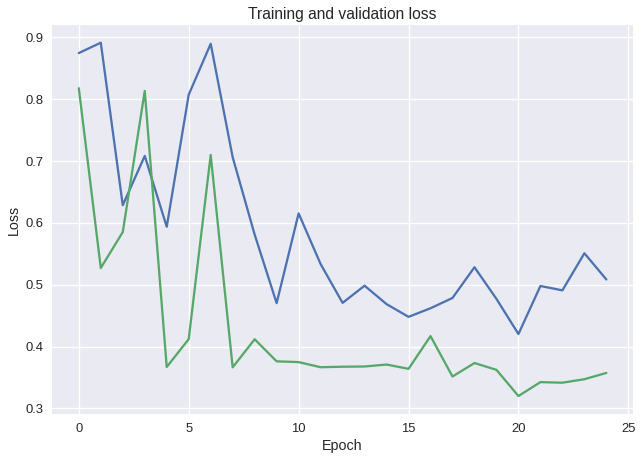

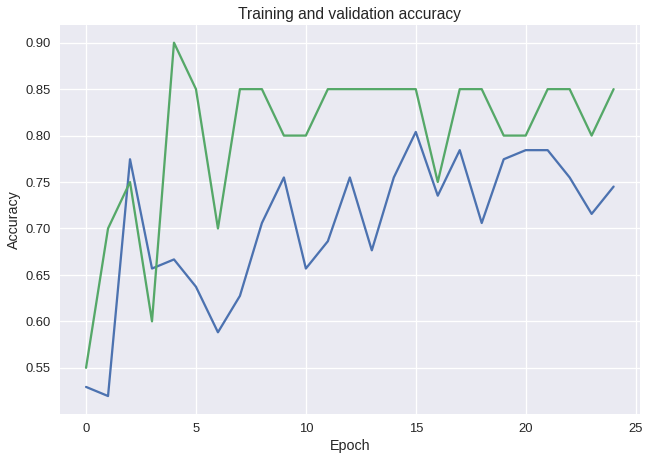

In [90]:
model_ft = train_model(model_ft, 
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler, 
                       'resnet18_all_params_optim_and_data_aug',
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6962 Acc: 0.5000
val Loss: 0.5083 Acc: 0.7000

Epoch 1/24
----------
train Loss: 0.7439 Acc: 0.6275
val Loss: 0.3363 Acc: 0.8500

Epoch 2/24
----------
train Loss: 0.6853 Acc: 0.6765
val Loss: 0.3419 Acc: 0.8000

Epoch 3/24
----------
train Loss: 0.6782 Acc: 0.6667
val Loss: 0.4240 Acc: 0.8000

Epoch 4/24
----------
train Loss: 0.7000 Acc: 0.6569
val Loss: 0.4830 Acc: 0.7500

Epoch 5/24
----------
train Loss: 0.5504 Acc: 0.7255
val Loss: 0.5130 Acc: 0.8000

Epoch 6/24
----------
train Loss: 0.5588 Acc: 0.7059
val Loss: 0.3432 Acc: 0.7500

Epoch 7/24
----------
train Loss: 0.6216 Acc: 0.7157
val Loss: 0.3519 Acc: 0.8500

Epoch 8/24
----------
train Loss: 0.4781 Acc: 0.8039
val Loss: 0.3793 Acc: 0.9000

Epoch 9/24
----------
train Loss: 0.4353 Acc: 0.7647
val Loss: 0.3161 Acc: 0.8500

Epoch 10/24
----------
train Loss: 0.4816 Acc: 0.7451
val Loss: 0.3030 Acc: 0.8500

Epoch 11/24
----------
train Loss: 0.4416 Acc: 0.7941
val Loss: 0.4173 Acc: 0.8000

Ep

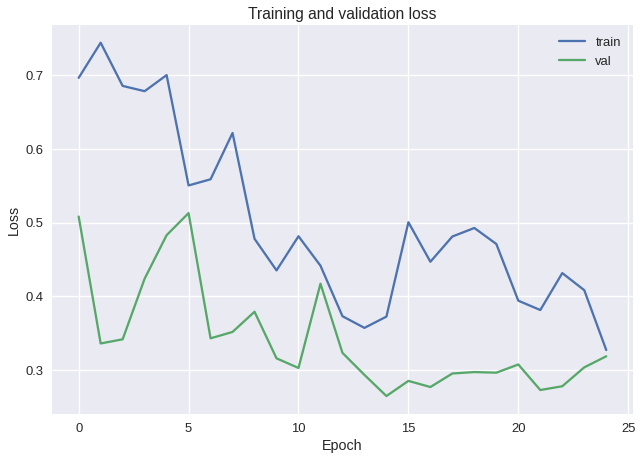

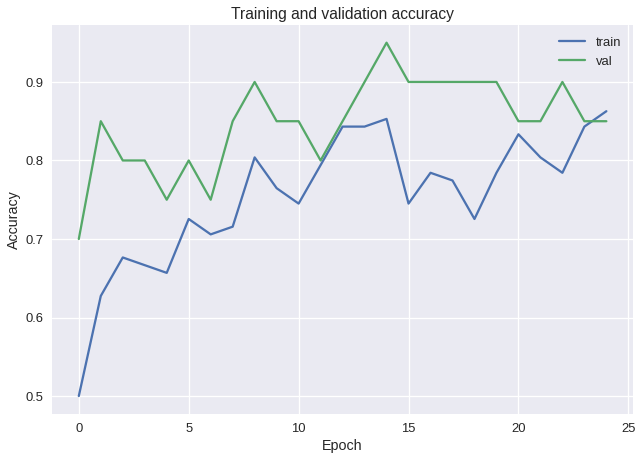

In [110]:
###########################
# ResNet 50 Experiements! #
###########################
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that **ALL** parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_name = 'resnet50_all_params_optim_and_data_aug'
model_ft = train_model(model_ft, 
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler, 
                       model_name,
                       num_epochs=25)

torch.save(model_ft.state_dict(), model_dir + model_name)

Epoch 0/24
----------
train Loss: 0.7578 Acc: 0.5000
val Loss: 0.5786 Acc: 0.6500

Epoch 1/24
----------
train Loss: 0.7692 Acc: 0.5784
val Loss: 0.5596 Acc: 0.6500

Epoch 2/24
----------
train Loss: 0.9254 Acc: 0.4608
val Loss: 1.1531 Acc: 0.5500

Epoch 3/24
----------
train Loss: 1.0589 Acc: 0.4804
val Loss: 0.6766 Acc: 0.6000

Epoch 4/24
----------
train Loss: 0.7378 Acc: 0.5686
val Loss: 0.6425 Acc: 0.7500

Epoch 5/24
----------
train Loss: 0.7089 Acc: 0.6176
val Loss: 0.4712 Acc: 0.7500

Epoch 6/24
----------
train Loss: 0.7094 Acc: 0.6078
val Loss: 0.8982 Acc: 0.6000

Epoch 7/24
----------
train Loss: 0.5452 Acc: 0.7451
val Loss: 0.4092 Acc: 0.8500

Epoch 8/24
----------
train Loss: 0.5195 Acc: 0.7059
val Loss: 0.5266 Acc: 0.8000

Epoch 9/24
----------
train Loss: 0.6047 Acc: 0.6471
val Loss: 0.4729 Acc: 0.8000

Epoch 10/24
----------
train Loss: 0.5466 Acc: 0.6961
val Loss: 0.4819 Acc: 0.8500

Epoch 11/24
----------
train Loss: 0.5695 Acc: 0.7157
val Loss: 0.5133 Acc: 0.8500

Ep

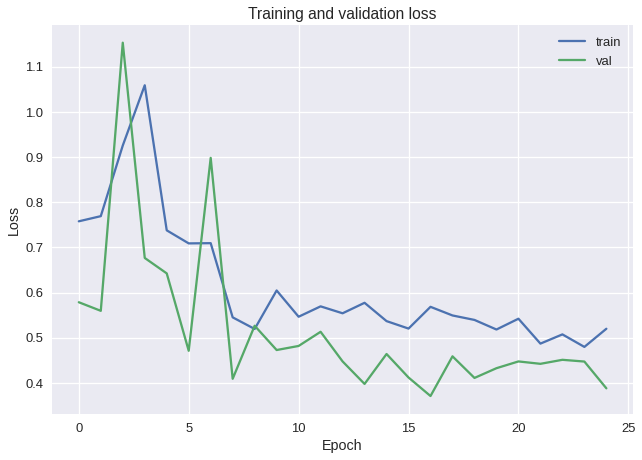

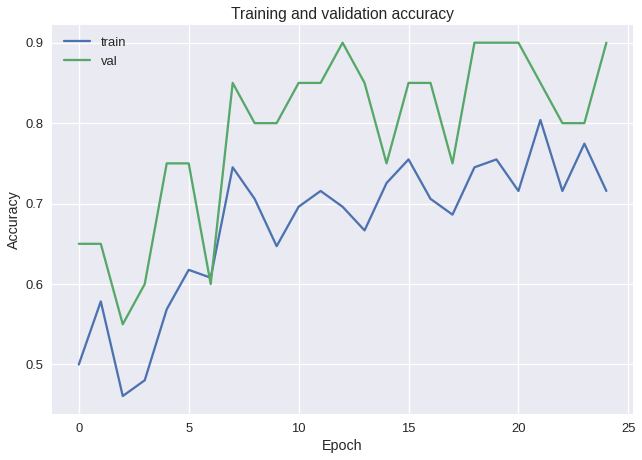

In [113]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that **A subset of** parameters are being optimized
for name, params in model_ft.named_parameters():
    if name != 'fc.weight':
        params.requires_grad=False
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_name = 'resnet50_fc_weight_optim'
model_ft = train_model(model_ft, 
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler, 
                       model_name,
                       num_epochs=25)

torch.save(model_ft.state_dict(), model_dir + model_name)

Epoch 0/24
----------
train Loss: 1.1201 Acc: 0.4902
val Loss: 0.5869 Acc: 0.5500

Epoch 1/24
----------
train Loss: 0.6348 Acc: 0.6961
val Loss: 0.3921 Acc: 0.8500

Epoch 2/24
----------
train Loss: 0.7342 Acc: 0.6471
val Loss: 0.3693 Acc: 0.9000

Epoch 3/24
----------
train Loss: 0.7085 Acc: 0.5980
val Loss: 0.4366 Acc: 0.8000

Epoch 4/24
----------
train Loss: 0.7524 Acc: 0.6863
val Loss: 0.3792 Acc: 0.8000

Epoch 5/24
----------
train Loss: 0.6732 Acc: 0.6667
val Loss: 0.3856 Acc: 0.7500

Epoch 6/24
----------
train Loss: 0.5865 Acc: 0.6863
val Loss: 0.2849 Acc: 0.9000

Epoch 7/24
----------
train Loss: 0.5327 Acc: 0.7157
val Loss: 0.2867 Acc: 0.9000

Epoch 8/24
----------
train Loss: 0.4255 Acc: 0.7843
val Loss: 0.3058 Acc: 0.9000

Epoch 9/24
----------
train Loss: 0.5104 Acc: 0.7353
val Loss: 0.2797 Acc: 0.9000

Epoch 10/24
----------
train Loss: 0.5140 Acc: 0.7353
val Loss: 0.4051 Acc: 0.7500

Epoch 11/24
----------
train Loss: 0.4798 Acc: 0.7353
val Loss: 0.2787 Acc: 0.8500

Ep

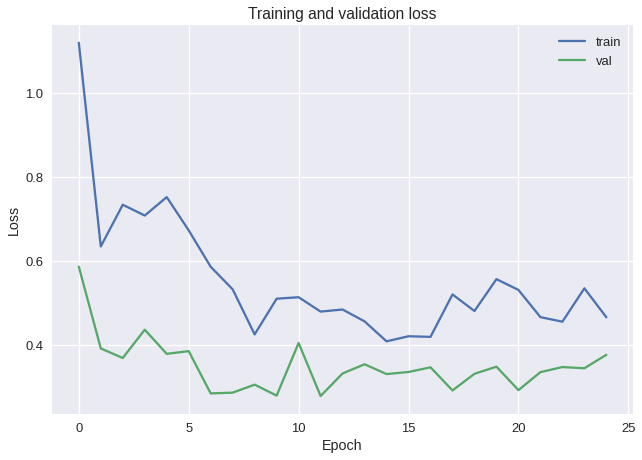

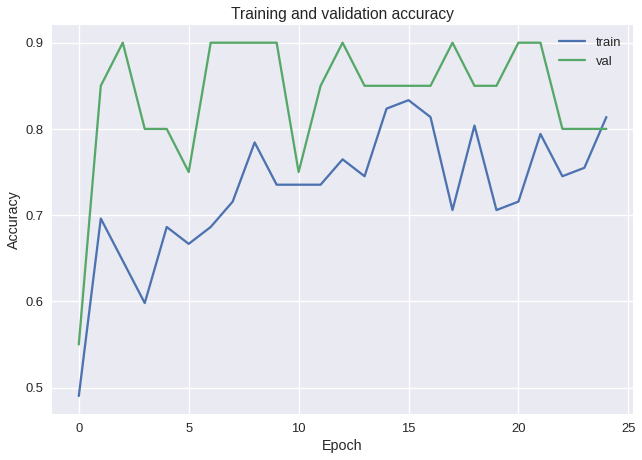

In [117]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that **A subset of** parameters are being optimized
for name, params in model_ft.named_parameters():
    if name != 'fc.weight' and not name.startswith('layer4'):
        params.requires_grad=False
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_name = 'resnet50_fc_weight_and_layer4_optim'
model_ft = train_model(model_ft, 
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler, 
                       model_name,
                       num_epochs=25)

torch.save(model_ft.state_dict(), model_dir + model_name)

In [13]:
# create test data loader
test_transforms = {
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
test_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                         test_transforms[x]) for x in ['test']}
test_dataloader = {x: torch.utils.data.DataLoader(test_datasets[x], batch_size=4,
                                                  shuffle=True, num_workers=4) 
                                                  for x in ['test']}
test_dataset_sizes = {x: len(test_datasets[x]) for x in ['test']}
test_class_names = test_datasets['test'].classes

In [127]:
for inputs, labels in test_dataloader['test']:
  print(labels)


tensor([0, 0, 0, 1])
tensor([0, 1, 1, 0])
tensor([0, 0, 1, 0])
tensor([1, 1, 1, 1])
tensor([0, 1, 1, 1])


In [7]:
# create test set evaluation helper
def eval_on_testset(model, name):
    model.eval()   # Set model to evaluate mode
    predictions = []
    true_labels = []
    for inputs, labels in test_dataloader['test']:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      for x in preds:
        predictions.append(x)
      for x in labels:
        true_labels.append(x)
    
    print('results for:', name)
    print('\tprecision: {0:.4f}'.format(precision_score(true_labels, predictions)))
    print('\trecall: {0:.4f}'.format(recall_score(true_labels, predictions)))
    print('\taccuracy {0:.4f}'.format(accuracy_score(true_labels, predictions)))
    print('\tF1: {0:.4f}'.format(f1_score(true_labels, predictions)))

In [173]:
################################
# Evaluation of ResNet models! #
################################

resnet_fc = models.resnet50()
num_ftrs = resnet_fc.fc.in_features
resnet_fc.fc = nn.Linear(num_ftrs, 2)
resnet_fc.load_state_dict(torch.load(model_dir + 'resnet50_fc_weight_optim'))
eval_on_testset(resnet_fc, 'resnet fc')

results for: resnet fc
	precision: 1.0000
	recall: 0.6364
	accuracy 0.8000
	F1: 0.7778


In [175]:
# Resnet fc + layer 4
resnet_fc_layer4 = models.resnet50()
resnet_fc_layer4.fc = nn.Linear(num_ftrs, 2)
resnet_fc_layer4.load_state_dict(torch.load(model_dir 
                                            + 'resnet50_fc_weight_and_layer4_optim'))
eval_on_testset(resnet_fc_layer4, 'resnet fc and layer 4')

results for: resnet fc and layer 4
	precision: 0.8000
	recall: 0.7273
	accuracy 0.7500
	F1: 0.7619


In [11]:
##############################
# Inception v3 Experiements! #
##############################

# need to resize our input data for the inception v3 network


data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}

data_dir = '/content/drive/MyDrive/Deep Learning Final Project/data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
# also redefine train to handle tuple returned from inceptionv3
def train_inception(model, criterion, optimizer, scheduler, name, num_epochs=25):
    since = time.time()

    model_epochs = []
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # log epochs for plotting
        model_epochs.append(epoch)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    if phase == 'val':
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, preds)
                    else:  # in training mode
                        outputs, aux_outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss1 = criterion(outputs, preds)
                        loss2 = criterion(aux_outputs, preds)
                        loss = loss1 + 0.4*loss2
                        
                        # backward + optimize only if in training phase
                        loss.backward() 
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            # store values for plot
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    # plot the training and validation loss
    plot_acc_and_loss(model_epochs, train_loss, train_acc, val_loss, val_acc, name)

    return model

Epoch 0/24
----------
train Loss: 1.5171 Acc: 0.5098
val Loss: 0.0019 Acc: 0.5500

Epoch 1/24
----------
train Loss: 0.0050 Acc: 0.5294
val Loss: 0.0009 Acc: 0.5500

Epoch 2/24
----------
train Loss: 0.0013 Acc: 0.5294
val Loss: 0.0009 Acc: 0.5500

Epoch 3/24
----------
train Loss: 0.0015 Acc: 0.5294
val Loss: 0.0008 Acc: 0.5500

Epoch 4/24
----------
train Loss: 0.0020 Acc: 0.5294
val Loss: 0.0006 Acc: 0.5500

Epoch 5/24
----------
train Loss: 0.0028 Acc: 0.5294
val Loss: 0.0007 Acc: 0.5500

Epoch 6/24
----------
train Loss: 0.0018 Acc: 0.5294
val Loss: 0.0007 Acc: 0.5500

Epoch 7/24
----------
train Loss: 0.0017 Acc: 0.5294
val Loss: 0.0006 Acc: 0.5500

Epoch 8/24
----------
train Loss: 0.0011 Acc: 0.5294
val Loss: 0.0008 Acc: 0.5500

Epoch 9/24
----------
train Loss: 0.0010 Acc: 0.5294
val Loss: 0.0007 Acc: 0.5500

Epoch 10/24
----------
train Loss: 0.0017 Acc: 0.5294
val Loss: 0.0005 Acc: 0.5500

Epoch 11/24
----------
train Loss: 0.0011 Acc: 0.5294
val Loss: 0.0005 Acc: 0.5500

Ep

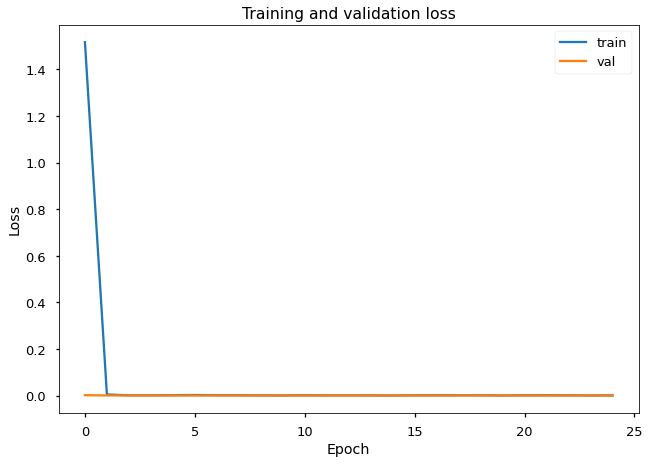

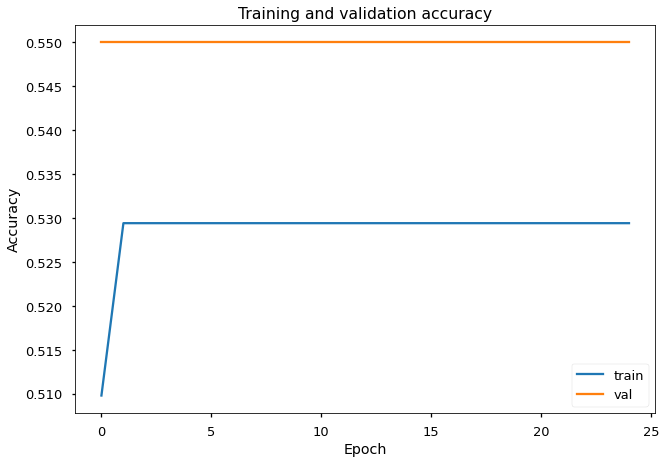

In [15]:
##############################
# Inception v3 Experiements! #
##############################

model_ft = models.inception_v3(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that **A subset of** parameters are being optimized
for name, params in model_ft.named_parameters():
    if name != 'fc.weight' and name != 'AuxLogits.fc.weight':
        params.requires_grad=False
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_name = 'inceptionv3_fc_and_auxlogits_fc_optim'
model_ft = train_inception(model_ft, 
                           criterion, 
                           optimizer_ft, 
                           exp_lr_scheduler, 
                           model_name,
                           num_epochs=25)

torch.save(model_ft.state_dict(), model_dir + model_name)

Epoch 0/24
----------
train Loss: 0.7570 Acc: 0.4608
val Loss: 0.7308 Acc: 0.4500

Epoch 1/24
----------
train Loss: 0.6848 Acc: 0.5686
val Loss: 0.6229 Acc: 0.6000

Epoch 2/24
----------
train Loss: 0.6607 Acc: 0.5588
val Loss: 0.6071 Acc: 0.7000

Epoch 3/24
----------
train Loss: 0.6195 Acc: 0.6667
val Loss: 0.5524 Acc: 0.7500

Epoch 4/24
----------
train Loss: 0.6328 Acc: 0.5980
val Loss: 0.5788 Acc: 0.6000

Epoch 5/24
----------
train Loss: 0.6930 Acc: 0.6275
val Loss: 0.7000 Acc: 0.5500

Epoch 6/24
----------
train Loss: 0.7895 Acc: 0.6176
val Loss: 0.5791 Acc: 0.6000

Epoch 7/24
----------
train Loss: 0.6842 Acc: 0.5490
val Loss: 0.5283 Acc: 0.8000

Epoch 8/24
----------
train Loss: 0.6515 Acc: 0.6176
val Loss: 0.5657 Acc: 0.7000

Epoch 9/24
----------
train Loss: 0.6073 Acc: 0.6863
val Loss: 0.6056 Acc: 0.6000

Epoch 10/24
----------
train Loss: 0.6468 Acc: 0.6176
val Loss: 0.5475 Acc: 0.7000

Epoch 11/24
----------
train Loss: 0.6407 Acc: 0.5980
val Loss: 0.5646 Acc: 0.6500

Ep

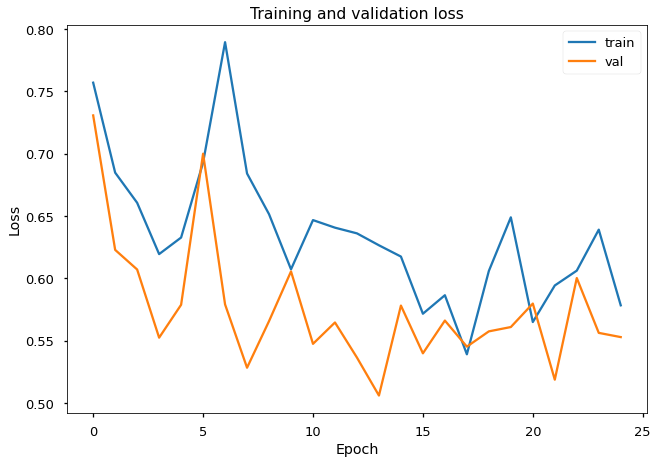

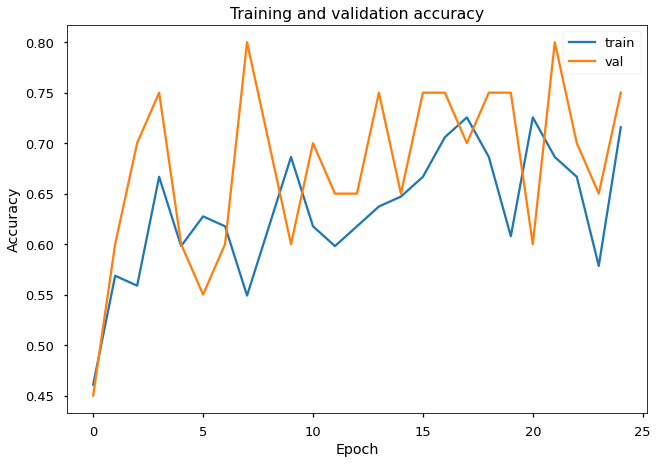

In [17]:
##############################
# Inception v3 Experiements! #
##############################

model_ft = models.inception_v3(pretrained=True, aux_logits=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that **A subset of** parameters are being optimized
for name, params in model_ft.named_parameters():
    if name != 'fc.weight':
        params.requires_grad=False
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_name = 'inceptionv3_fc_optim'
model_ft = train_model(model_ft, 
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler, 
                       model_name,
                       num_epochs=25)

torch.save(model_ft.state_dict(), model_dir + model_name)

In [22]:
#####################################
# Evaluation of Inceptionv3 models! #
#####################################
inception_fc_and_aux = models.inception_v3(pretrained=True)
inception_fc_and_aux.fc = nn.Linear(num_ftrs, 2)
inception_fc_and_aux.load_state_dict(torch.load(model_dir 
                                            + 'inceptionv3_fc_and_auxlogits_fc_optim'))
eval_on_testset(inception_fc_and_aux, 'inceptionv3 fc and aux')

results for: inceptionv3 fc and aux
	precision: 0.5500
	recall: 1.0000
	accuracy 0.5500
	F1: 0.7097


In [42]:
inception_fc = models.inception_v3(pretrained=True, aux_logits=False)
inception_fc .fc = nn.Linear(num_ftrs, 2)
inception_fc .load_state_dict(torch.load(model_dir 
                                            + 'inceptionv3_fc_optim'))
eval_on_testset(inception_fc , 'inceptionv3 fc')

results for: inceptionv3 fc
	precision: 0.7692
	recall: 0.9091
	accuracy 0.8000
	F1: 0.8333


Epoch 0/24
----------
train Loss: 0.7029 Acc: 0.5588
val Loss: 0.6144 Acc: 0.6000

Epoch 1/24
----------
train Loss: 0.7888 Acc: 0.5490
val Loss: 0.6814 Acc: 0.6000

Epoch 2/24
----------
train Loss: 0.8188 Acc: 0.4706
val Loss: 0.6382 Acc: 0.6000

Epoch 3/24
----------
train Loss: 0.7582 Acc: 0.5784
val Loss: 0.6418 Acc: 0.7500

Epoch 4/24
----------
train Loss: 0.7008 Acc: 0.6275
val Loss: 0.6088 Acc: 0.7000

Epoch 5/24
----------
train Loss: 0.7645 Acc: 0.6667
val Loss: 0.4306 Acc: 0.8500

Epoch 6/24
----------
train Loss: 0.6731 Acc: 0.6176
val Loss: 0.4854 Acc: 0.7000

Epoch 7/24
----------
train Loss: 0.5625 Acc: 0.6765
val Loss: 0.4391 Acc: 0.8000

Epoch 8/24
----------
train Loss: 0.6029 Acc: 0.7353
val Loss: 0.4526 Acc: 0.8000

Epoch 9/24
----------
train Loss: 0.6280 Acc: 0.6569
val Loss: 0.4438 Acc: 0.8000

Epoch 10/24
----------
train Loss: 0.7223 Acc: 0.6176
val Loss: 0.4367 Acc: 0.8000

Epoch 11/24
----------
train Loss: 0.5487 Acc: 0.7549
val Loss: 0.4369 Acc: 0.8000

Ep

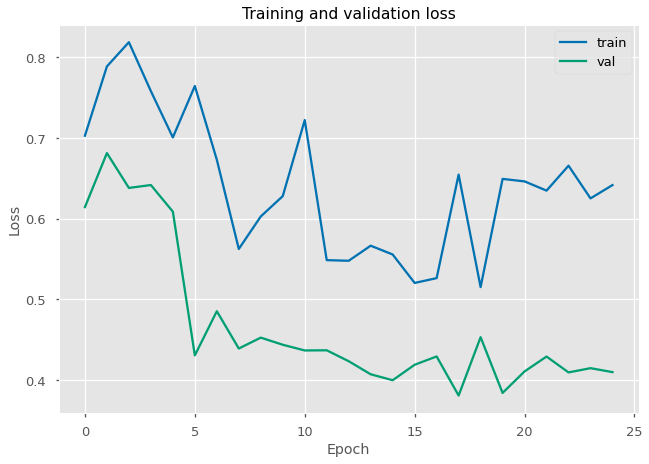

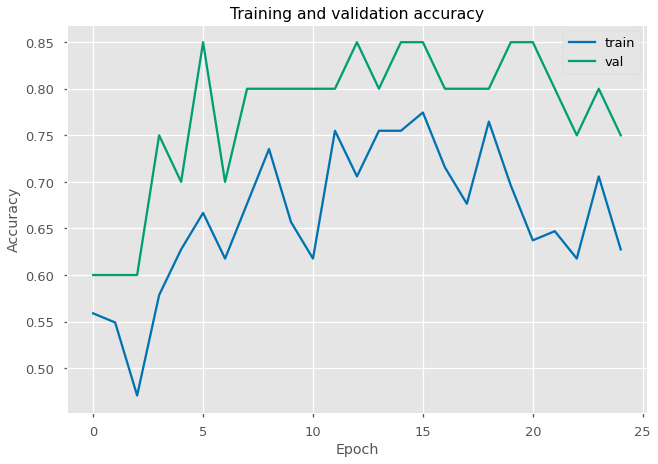

In [51]:
#######################
# VGG-16 Experiments! #
#######################
model_ft = models.vgg16_bn(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs, 2) # replace last fc layer

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that **A subset of** parameters are being optimized
for name, params in model_ft.named_parameters():
    if name != 'classifier.6.weight':
        params.requires_grad=False
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_name = 'vgg16_bn_final_fc_weight'
model_ft = train_model(model_ft, 
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler, 
                       model_name,
                       num_epochs=25)

torch.save(model_ft.state_dict(), model_dir + model_name)

Epoch 0/24
----------
train Loss: 0.7052 Acc: 0.5000
val Loss: 0.6601 Acc: 0.5500

Epoch 1/24
----------
train Loss: 0.6780 Acc: 0.5588
val Loss: 0.6333 Acc: 0.6000

Epoch 2/24
----------
train Loss: 0.6934 Acc: 0.4706
val Loss: 0.5645 Acc: 0.8000

Epoch 3/24
----------
train Loss: 0.6526 Acc: 0.6275
val Loss: 0.5808 Acc: 0.7500

Epoch 4/24
----------
train Loss: 0.6736 Acc: 0.5588
val Loss: 0.5262 Acc: 0.8000

Epoch 5/24
----------
train Loss: 0.6435 Acc: 0.6078
val Loss: 0.6172 Acc: 0.5500

Epoch 6/24
----------
train Loss: 0.6180 Acc: 0.6373
val Loss: 0.4599 Acc: 0.9000

Epoch 7/24
----------
train Loss: 0.6248 Acc: 0.6078
val Loss: 0.4339 Acc: 0.9500

Epoch 8/24
----------
train Loss: 0.5810 Acc: 0.7059
val Loss: 0.4295 Acc: 0.9000

Epoch 9/24
----------
train Loss: 0.6218 Acc: 0.6373
val Loss: 0.4321 Acc: 0.9000

Epoch 10/24
----------
train Loss: 0.5861 Acc: 0.6569
val Loss: 0.4370 Acc: 0.9000

Epoch 11/24
----------
train Loss: 0.5960 Acc: 0.7255
val Loss: 0.4457 Acc: 0.8500

Ep

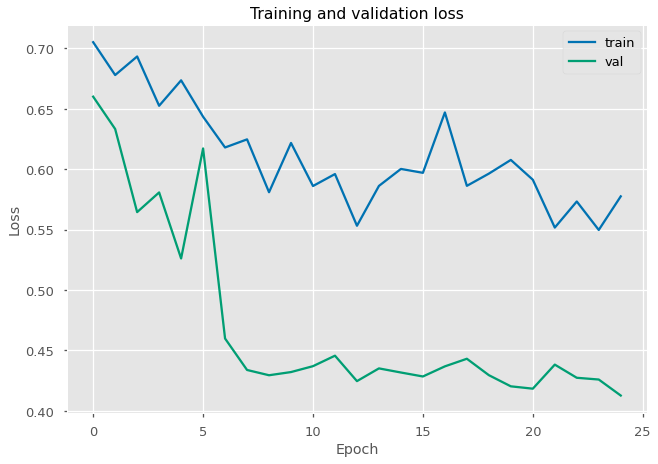

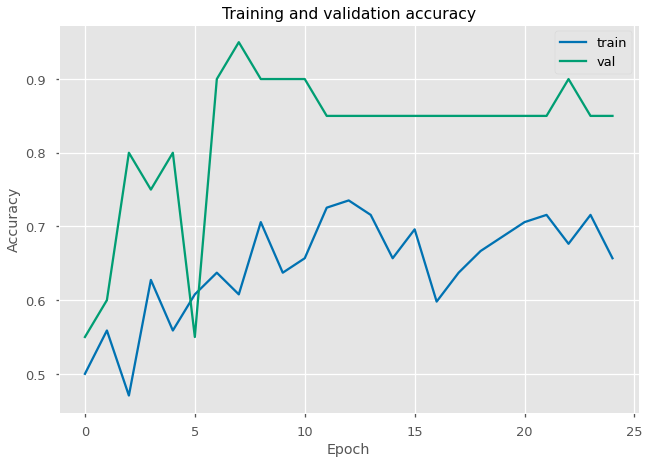

In [53]:
# Retrain last 2 FCs! of VGG-16

model_ft = models.vgg16_bn(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[3] = nn.Linear(num_ftrs, num_ftrs) # replace 2nd to last layer
model_ft.classifier[6] = nn.Linear(num_ftrs, 2) # replace last fc layer

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that **A subset of** parameters are being optimized
for name, params in model_ft.named_parameters():
    if name != 'classifier.6.weight' and name != 'classifier.3.weight':
        params.requires_grad=False
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_name = 'vgg16_bn_last_two_fc_weights'
model_ft = train_model(model_ft, 
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler, 
                       model_name,
                       num_epochs=25)

torch.save(model_ft.state_dict(), model_dir + model_name)

In [16]:
################################
# Evaluation of VGG-16 models! #
################################

vgg_fc = models.vgg16_bn()
num_ftrs = vgg_fc.classifier[6].in_features
vgg_fc.classifier[6] = nn.Linear(num_ftrs, 2) # replace last fc layer
vgg_fc.load_state_dict(torch.load(model_dir + 'vgg16_bn_final_fc_weight'))
eval_on_testset(vgg_fc, 'vgg fc')

results for: vgg fc
	precision: 0.7500
	recall: 0.5455
	accuracy 0.6500
	F1: 0.6316


In [17]:
vgg_last_two_fc = models.vgg16_bn()
num_ftrs = vgg_last_two_fc.classifier[6].in_features
vgg_last_two_fc.classifier[6] = nn.Linear(num_ftrs, 2) # replace last fc layer
vgg_last_two_fc.load_state_dict(torch.load(model_dir + 'vgg16_bn_last_two_fc_weights'))
eval_on_testset(vgg_last_two_fc, 'vgg fc last two')

results for: vgg fc last two
	precision: 0.6250
	recall: 0.9091
	accuracy 0.6500
	F1: 0.7407
